In [2]:
import pandas as pd
import warnings

from dakkoai import (
    DakkoAIClient,
    DakkoRegistrationModel,
    DakkoSearch as DakkoSQL,
)

from functools import reduce
from datetime import datetime

warnings.filterwarnings("ignore")

## Utility


In [3]:
def parse_args_complex(df: pd.DataFrame, names: str, args: str):
    # get first row of the column

    unique_names = df[names].unique()
    new_columns = [x.split(",") for x in unique_names]
    new_columns = reduce(lambda x, y: x + y, new_columns)

    df[new_columns] = None

    new_df = pd.DataFrame()

    for combo in unique_names:
        slice_df = df[df[names] == combo].copy()
        slice_df[combo.split(",")] = slice_df[args].str.split(";", expand=True)
        new_df = pd.concat([new_df, slice_df])

    new_df.drop(columns=[args, names], inplace=True)

    return new_df


# --------------------------- #


def parse_args_simple(data: pd.DataFrame, names: str, args: str):
    df = data.copy()
    new_names = df[names].values[0].split(",")
    df[new_names] = df[args].str.split(";", expand=True)

    df.drop(columns=[args, names], inplace=True)

    return df


# --------------------------- #


def parse_liquidity_df(df: pd.DataFrame) -> pd.DataFrame:
    ld_df = df.copy()
    liqiq = parse_args_complex(ld_df, "indexed_names", "indexed_args")
    liqiq = parse_args_complex(liqiq, "not_indexed_names", "not_indexed_args")
    liqiq["timestamp"] = pd.to_datetime(liqiq["timestamp"])

    # copy events with token id
    liqiq_id = liqiq[
        liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])
    ].copy()

    # copy events without token id
    liquiq_not_id = liqiq[
        ~liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])
    ].copy()

    # build mapping between positions and tick ranges
    tokenId_to_ticks = (
        (
            liqiq_id.drop(columns=["tickUpper", "tickLower"]).merge(
                liquiq_not_id[["transactionHash", "tickUpper", "tickLower"]],
                how="inner",
                on="transactionHash",
            )
        )[["tokenId", "tickUpper", "tickLower"]]
        .drop_duplicates()
        .reset_index(drop=True)
        .to_dict("records")
    )

    # remap
    tokenId_to_ticks_new = dict()

    for x in tokenId_to_ticks:
        tokenId_to_ticks_new[x["tokenId"]] = (x["tickUpper"], x["tickLower"])

    # apply for original df

    liqiq["tickUpper"] = liqiq.apply(
        lambda x: (
            tokenId_to_ticks_new[x["tokenId"]][0]
            if x["tokenId"] is not None
            else x["tickUpper"]
        ),
        axis=1,
    )
    liqiq["tickLower"] = liqiq.apply(
        lambda x: (
            tokenId_to_ticks_new[x["tokenId"]][1]
            if x["tokenId"] is not None
            else x["tickLower"]
        ),
        axis=1,
    )

    # rebuild liquidity column using all events now
    liqiq.liquidity = liqiq.apply(
        lambda x: float(x.liquidity) if x.liquidity is not None else float(x.amount),
        axis=1,
    )

    # convert to numeric
    for col in ["amount0", "amount1"]:
        liqiq[col] = liqiq[col].astype(float)

    liqiq.tickLower = liqiq.tickLower.astype(int)
    liqiq.tickUpper = liqiq.tickUpper.astype(int)

    # add multiplier for corresponding events
    for col in ["liquidity", "amount0", "amount1"]:
        liqiq[col] *= liqiq.event.apply(
            lambda x: -1 if x in ["DecreaseLiquidity", "Burn"] else 1
        )

    liqiq.drop_duplicates(["transactionHash", "liquidity"], inplace=True)

    liqiq.sort_values(by="timestamp", inplace=True)
    liqiq.reset_index(drop=True, inplace=True)

    return liqiq


# --------------------------- #


def get_liq_ticks(df: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    unique_ticks = sorted(set(df["tickLower"]).union(set(df["tickUpper"])))

    tick_liquidity = pd.DataFrame(unique_ticks, columns=["tick"]).set_index("tick")
    tick_liquidity["totalLiquidity"] = 0
    tick_liquidity["amount0locked"] = 0
    tick_liquidity["amount1locked"] = 0

    for _, row in df.iterrows():
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "totalLiquidity"] += (
            row["liquidity"]
        )
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount0locked"] += row[
            "amount0"
        ]
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount1locked"] += row[
            "amount1"
        ]

    tick_liquidity = tick_liquidity.reset_index()

    tick_liquidity["price"] = 1.0001 ** tick_liquidity["tick"] * 10 ** (dec1 - dec0)

    tick_liquidity["tick_width"] = tick_liquidity["tick"].diff().shift(-1).fillna(0)
    tick_liquidity["price_width"] = tick_liquidity["price"].diff().shift(-1).fillna(0)

    return tick_liquidity

## Dakko SDK Functions


In [4]:
import time


def get_pool_events(pool: str, dakko_client: DakkoAIClient):
    pool = pool.lower()

    query = f"""
    SELECT DISTINCT * FROM (
        SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
        WHERE address = '{pool}'
    )
    INNER JOIN (
        SELECT DISTINCT indexed_names, not_indexed_names, signature 
        FROM dakko_poc.eth_static.event_registry_with_meta
    ) USING(signature)
    INNER JOIN (
        SELECT DISTINCT `from` as tx_from, transactionHash
        FROM dakko_poc.eth_bronze.raw_blocks_receipts
    ) USING(transactionHash)
    """

    query = DakkoSQL(query=query)
    evts = dakko_client.get_query_results(query).dataframe

    return evts


# --------------------------- #


def get_token_transfers(token: str, dakko_client: DakkoAIClient):
    token = token.lower()

    # get token transfers
    query = f"""
    SELECT DISTINCT * FROM (
        SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
        WHERE address = '{token}' AND event = 'Transfer'
    )
    INNER JOIN (
        SELECT indexed_names, not_indexed_names, signature 
        FROM dakko_poc.eth_static.event_registry_with_meta
    ) USING(signature)
    INNER JOIN (
        SELECT DISTINCT `from` as tx_from, transactionHash
        FROM dakko_poc.eth_bronze.raw_blocks_receipts
    ) USING(transactionHash)
    """
    query = DakkoSQL(query=query)
    evts = dakko_client.get_query_results(query).dataframe

    return evts


# --------------------------- #


def _parse_evt_args(data: pd.DataFrame):
    df = data.copy()
    df = parse_args_simple(df, "indexed_names", "indexed_args")
    df = parse_args_simple(df, "not_indexed_names", "not_indexed_args")

    return df


# --------------------------- #


def _post_abstract(data: pd.DataFrame):
    data = _parse_evt_args(data)
    data["timestamp"] = pd.to_datetime(data["timestamp"]).dt.tz_localize(None)

    return data


# --------------------------- #


def get_processed_swaps(data: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    df = data.copy()
    df = _post_abstract(df)

    df["amount0"] = df["amount0"].astype(float) / 10**dec0
    df["amount1"] = df["amount1"].astype(float) / 10**dec1
    df["price"] = (
        (df["sqrtPriceX96"].astype(float) / 2**96) ** 2 / 10 ** (dec0 - dec1)
    ).astype(float)

    df.drop(columns=["sqrtPriceX96"], inplace=True)

    return df


# --------------------------- #


def get_processed_mints(data: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    df = data.copy()
    df = _post_abstract(df)

    df["amount0"] = df["amount0"].astype(float) / 10**dec0
    df["amount1"] = df["amount1"].astype(float) / 10**dec1

    df["tickUpper"] = df["tickUpper"].astype(int)
    df["tickLower"] = df["tickLower"].astype(int)
    df["amount"] = df["amount"].astype(float)

    return df


# --------------------------- #


def postprocess_pool_events(data: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    df = data.copy()

    swaps = df[df.event == "Swap"].copy().reset_index(drop=True)
    collects = df[df.event == "Collect"].copy().reset_index(drop=True)
    burns = df[df.event == "Burn"].copy().reset_index(drop=True)
    mints = df[df.event == "Mint"].copy().reset_index(drop=True)

    swaps = get_processed_swaps(swaps, dec0=dec0, dec1=dec1)
    collects = _post_abstract(collects)
    burns = get_processed_mints(burns)
    mints = get_processed_mints(mints)

    return swaps, collects, burns, mints


# --------------------------- #


def get_processed_pool_events(pool: str):
    pool = pool.lower()
    evts = get_pool_events(pool, dakko_client)
    swaps, collects, burns, mints = postprocess_pool_events(evts)
    swaps.set_index("timestamp", inplace=True)

    swaps_1h = swaps.resample("1H").agg(
        {
            "amount0": "sum",
            "amount1": "sum",
            "price": "ohlc",
        }
    )

    swaps_vol = swaps.resample("6H").agg(
        {
            "amount0": "sum",
            "amount1": "sum",
            "price": "ohlc",
        }
    )

    swaps_1h[["amount0", "amount1"]].fillna(0, inplace=True)
    swaps_1h.fillna(method="ffill", inplace=True)
    swaps_1h.columns = swaps_1h.columns.droplevel(0)

    swaps_vol[["amount0", "amount1"]].fillna(0, inplace=True)
    swaps_vol.fillna(method="ffill", inplace=True)
    swaps_vol.columns = swaps_vol.columns.droplevel(0)

    return swaps_1h, swaps_vol, mints, burns


# --------------------------- #


def plot_token_price(swaps, dex, symbol, start_dt, end_dt, ax=None, **kwargs):
    import matplotlib.pyplot as plt

    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    swaps.plot(y="close", ax=ax, color="black", linewidth=1)

    _ = ax.set_xlim(max(start_dt, swaps.index.min()), min(end_dt, swaps.index.max()))
    ax.set_title(f"{dex.capitalize()}: {symbol} | Price Level", fontsize=16, pad=15)
    ax.set_ylabel(f"Price {symbol}", fontsize=14, labelpad=15)

    return ax


# --------------------------- #


def temp_plot_liq_changes(mints, burns, start_dt, end_dt, ax=None):
    import matplotlib.pyplot as plt

    mints_se = mints[
        (mints["timestamp"] >= start_dt) & (mints["timestamp"] <= end_dt)
    ].copy()
    burns_se = burns[
        (burns["timestamp"] >= start_dt) & (burns["timestamp"] <= end_dt)
    ].copy()
    mints_liq = mints_se.copy()
    burns_liq = burns_se.copy()
    mints_liq["liquidity"] = mints_liq["amount"].astype(float)
    burns_liq["liquidity"] = -burns_liq["amount"].astype(float)

    all_liq = pd.concat([mints_liq, burns_liq], ignore_index=True).reset_index(
        drop=True
    )

    ticks_changes = get_liq_ticks(all_liq)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(
        ticks_changes["price"],
        ticks_changes["totalLiquidity"] / 5e17,
        width=ticks_changes["price_width"],
        align="edge",
        color="blue",
        label="Liquidity",
        alpha=0.2,
    )

    ax.set_ylabel("Liquidity", labelpad=15)
    ax.set_xlabel("Price", labelpad=15)

    ax.set_xlim(5e-3, 9e-3)

    return ax


# --------------------------- #


def temp_get_participants(mints, burns, start_dt, end_dt):
    mints_se = mints[
        (mints["timestamp"] >= start_dt) & (mints["timestamp"] <= end_dt)
    ].copy()
    burns_se = burns[
        (burns["timestamp"] >= start_dt) & (burns["timestamp"] <= end_dt)
    ].copy()
    mints_liq = mints_se.copy()
    burns_liq = burns_se.copy()
    mints_liq["liquidity"] = mints_liq["amount"].astype(float)
    burns_liq["liquidity"] = -burns_liq["amount"].astype(float)

    all_liq = pd.concat([mints_liq, burns_liq], ignore_index=True).reset_index(
        drop=True
    )

    all_liq = all_liq[["tx_from", "liquidity", "tickUpper", "tickLower"]].copy()
    all_liq = (
        all_liq.groupby(["tx_from", "tickUpper", "tickLower"])
        .agg({"liquidity": "sum"})
        .reset_index()
        .sort_values(by="liquidity", ascending=False)
        .reset_index(drop=True)
    )

    return all_liq


# --------------------------- #


def plot_token_price_with_liquidity_changes(
    swaps_1h,
    mints,
    burns,
    dex,
    symbol,
    s_start_dt,
    s_end_dt,
    liq_start_dt,
    liq_end_dt,
    **kwargs,
):
    import matplotlib.pyplot as plt

    fig, (ax, ax2) = plt.subplots(1, 2, **kwargs)

    ax = plot_token_price(swaps_1h, dex, symbol, s_start_dt, s_end_dt, ax=ax)
    temp_plot_liq_changes(mints, burns, liq_start_dt, liq_end_dt, ax=ax2)

    ax.vlines(
        liq_end_dt,
        swaps_1h.close.min(),
        swaps_1h.close.max(),
        color="red",
        linestyle="--",
        label="Price drop started",
    )
    ax.axvspan(
        liq_start_dt,
        liq_end_dt,
        alpha=0.2,
        color="blue",
        label="Liquidity changes period",
    )
    ax.axvspan(
        liq_end_dt,
        datetime(2024, 1, 13),
        alpha=0.04,
        color="red",
        label="Price drop period",
    )
    ax.legend()

    _ = ax2.set_title(
        f"{dex.capitalize()}: {symbol} | Liquidity Changes", fontsize=16, pad=15
    )


# --------------------------- #


def get_significant_wallets(mints, burns, liq_start_dt, liq_end_dt, pa_size: int = 1):
    pa = temp_get_participants(mints, burns, liq_start_dt, liq_end_dt)

    pos_pa = (
        pa.sort_values(by="liquidity", ascending=False).head(pa_size).tx_from.tolist()
    )
    neg_pa = (
        pa.sort_values(by="liquidity", ascending=True).head(pa_size).tx_from.tolist()
    )

    return pos_pa, neg_pa


# --------------------------- #


def plot_counterfactual_price_liquidity(
    swaps_1h,
    swaps_vol,
    mints,
    burns,
    dex,
    symbol,
    s_start_dt,
    s_end_dt,
    liq_start_dt,
    liq_end_dt,
    sw_size: int = 1,
    **kwargs,
):
    import matplotlib.pyplot as plt

    pos_pa, neg_pa = get_significant_wallets(
        mints, burns, liq_start_dt, liq_end_dt, sw_size
    )

    fig, ax = plt.subplots(**kwargs)

    price_level = ax.plot(
        swaps_1h.index, swaps_1h["close"], alpha=1, label="Close price", color="black"
    )

    ax2 = ax.twinx()

    volumes = ax2.bar(
        swaps_vol.index,
        abs(swaps_vol["amount0"]),
        color="black",
        alpha=0.1,
        label="Volume",
        width=0.2,
    )

    _ = ax.set_xlim(s_start_dt, s_end_dt)
    _ = ax2.set_xlim(s_start_dt, s_end_dt)

    participant_burns = burns[burns.tx_from.isin(neg_pa)].copy()
    participant_burns["priceLower"] = participant_burns["tickLower"].apply(
        lambda x: 1.0001**x * 10 ** (18 - 18)
    )
    participant_burns["priceUpper"] = participant_burns["tickUpper"].apply(
        lambda x: 1.0001**x * 10 ** (18 - 18)
    )

    liq_drainage_evts = ax.vlines(
        x=participant_burns["timestamp"].values,
        ymin=participant_burns["priceLower"],
        ymax=participant_burns["priceUpper"],
        alpha=0.6,
        color="red",
        label="Liquidiy drainage by significant wallets",
        linewidth=2,
    )

    lns = [liq_drainage_evts, volumes, price_level[0]]
    labs = [li.get_label() for li in lns]
    ax.legend(lns, labs, loc=0)

    ax.set_title(
        f"{dex.capitalize()}: {symbol} | Counterfactual Price Analysis Based on Labeled Wallets",
        fontsize=16,
        pad=15,
    )
    ax.set_xlabel("Date", labelpad=15, fontsize=14)
    ax2.set_ylabel("Volume", labelpad=15, fontsize=14)
    _ = ax.set_ylabel("Price", labelpad=15, fontsize=14)

    return participant_burns


# --------------------------- #


def get_liquidity_drainage_stats(
    mints, burns, liq_start_dt, liq_end_dt, pa_size: int = 1
):
    pos_pa, neg_pa = get_significant_wallets(
        mints, burns, liq_start_dt, liq_end_dt, pa_size
    )
    participant_burns = burns[burns.tx_from.isin(neg_pa)].copy()
    print(f"Total wallets participated: {participant_burns.tx_from.unique().size}")

    participant_burns["priceLower"] = 1.0001 ** participant_burns["tickLower"]
    participant_burns["priceUpper"] = 1.0001 ** participant_burns["tickUpper"]

    return participant_burns.rename(columns={"tx_from": "wallet"})[
        [
            "transactionHash",
            "wallet",
            "timestamp",
            "amount0",
            "amount1",
            "priceLower",
            "priceUpper",
        ]
    ].copy()


# --------------------------- #


def analyze_significant_wallets(
    participant_burns, mints, burns, liq_start_dt, liq_end_dt, pa_size: int = 1
):
    pos_pa, neg_pa = get_significant_wallets(
        mints, burns, liq_start_dt, liq_end_dt, pa_size
    )
    ts = int(participant_burns["timestamp"].min().timestamp())
    neg_pa_join = ", ".join([f"'{x}'" for x in neg_pa])

    query = f"""
        SELECT DISTINCT * FROM (
            SELECT * FROM dakko_poc.eth_bronze.parsed_transaction_logs_refine
            WHERE timestamp >= FROM_UNIXTIME({ts})
        )
        INNER JOIN (
            SELECT DISTINCT indexed_names, not_indexed_names, signature 
            FROM dakko_poc.eth_static.event_registry_with_meta
        ) USING(signature)
        INNER JOIN (
            SELECT DISTINCT `from` as tx_from, transactionHash
            FROM dakko_poc.eth_bronze.raw_blocks_receipts
            WHERE `from` IN ({neg_pa_join})
        ) USING(transactionHash)
        """
    query = DakkoSQL(query=query)
    evts = dakko_client.get_query_results(query).dataframe

    return evts


# --------------------------- #


def get_significant_events_by_token(token, sw_events):
    weth_events = sw_events[sw_events.address == token].copy()
    weth_transfers = weth_events[
        (weth_events.event == "Transfer")
        & (~weth_events.not_indexed_args.isnull())
        & (weth_events.not_indexed_names == "value")
    ].copy()

    weth_transfers = parse_args_simple(weth_transfers, "indexed_names", "indexed_args")
    weth_transfers = parse_args_simple(
        weth_transfers, "not_indexed_names", "not_indexed_args"
    )

    weth_transfers["value"] = weth_transfers["value"].astype(float) / 10**18

    weth_transfers.sort_values(by="timestamp", inplace=True)
    weth_transfers.reset_index(drop=True, inplace=True)

    return (
        weth_transfers.rename(columns={"tx_from": "wallet"})[
            [
                "transactionHash",
                "wallet",
                "timestamp",
                "event",
                "value",
                "to",
            ]
        ]
        .copy()
        .sort_values("timestamp")
    )


# --------------------------- #


def sent_websocket_notification(*args, **kwargs):
    print("Sending...")
    time.sleep(0.1)

    print("Sent message to Dakko websocket, check notifications")


# --------------------------- #

dakko_client = DakkoAIClient()
user_data = DakkoRegistrationModel(
    email="user@example.com", first_name="John", last_name="Doe", user_name="johndoe"
)

dakko_client.register(user_data)
dakko_client.get_access_token()

LINK_WETH = "0xa6Cc3C2531FdaA6Ae1A3CA84c2855806728693e8"

dakko_client.get_processed_pool_events = get_processed_pool_events
dakko_client.plot_token_price = plot_token_price
dakko_client.plot_token_price_with_liquidity_changes = (
    plot_token_price_with_liquidity_changes
)
dakko_client.plot_counterfactual_price_liquidity = plot_counterfactual_price_liquidity
dakko_client.get_significant_wallets = get_significant_wallets
dakko_client.get_liquidity_drainage_stats = get_liquidity_drainage_stats
dakko_client.analyze_significant_walelts = analyze_significant_wallets
dakko_client.sent_websocket_notification = sent_websocket_notification
dakko_client.get_significant_events_by_token = get_significant_events_by_token
dakko_client.LINK_WETH_UNI3 = LINK_WETH
dakko_client.WETH = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"

## Main body


In [5]:
swaps_1h, swaps_vol, mints, burns = dakko_client.get_processed_pool_events(
    dakko_client.LINK_WETH_UNI3
)

Plot price level for a particular timeframe


<Axes: title={'center': 'Uniswap: LINK/WETH | Price Level'}, xlabel='timestamp', ylabel='Price LINK/WETH'>

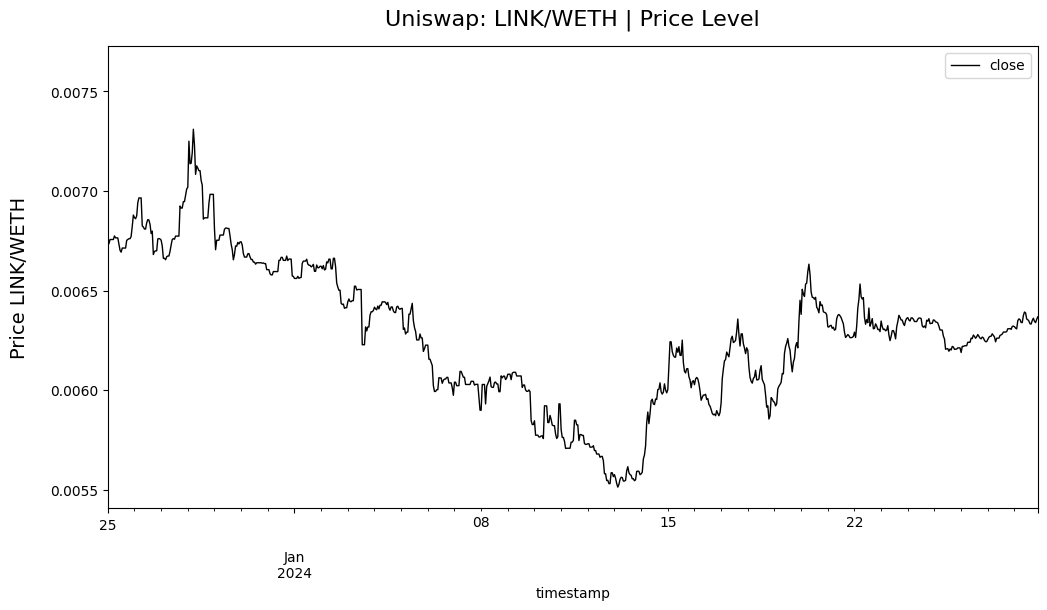

In [6]:
s_start_dt = datetime(2023, 12, 25)
s_end_dt = datetime(2024, 1, 30)

# plot token price
dakko_client.plot_token_price(
    swaps_1h,
    start_dt=s_start_dt,
    end_dt=s_end_dt,
    symbol="LINK/WETH",
    dex="uniswap",
    figsize=(12, 6),
)

-   We can notice the price drop between 2023-12-28 and 2024-01-14 by about 10-15% which is quite significant
-   Assumption: liquidity changes in this pool are very impactful for the price


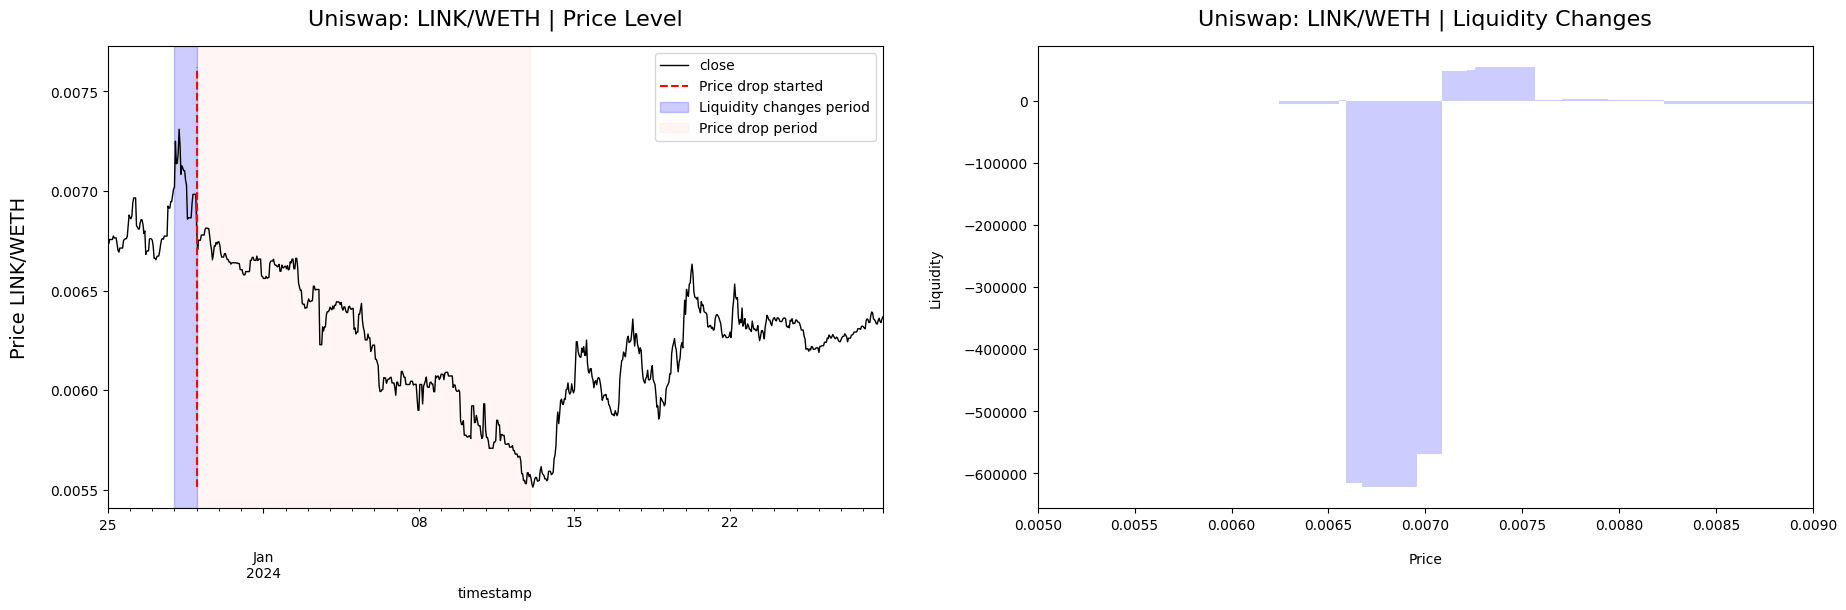

In [10]:
liq_start_dt = datetime(2023, 12, 28)
liq_end_dt = datetime(2023, 12, 29)


dakko_client.plot_token_price_with_liquidity_changes(
    swaps_1h,
    mints,
    burns,
    symbol="LINK/WETH",
    dex="uniswap",
    s_start_dt=s_start_dt,
    s_end_dt=s_end_dt,
    liq_start_dt=liq_start_dt,
    liq_end_dt=liq_end_dt,
    figsize=(22, 6),
)

Validate the hypothesis


,transactionHash,signature,address,logIndex,event,timestamp,tx_from,owner,tickLower,tickUpper,amount,amount0,amount1,priceLower,priceUpper
215,0x03955c3099fe697805e4accc9323b3123400ff384dd0...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x160,Burn,2024-01-22 07:05:35,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-51120,-50520,2.611788e+23,0.0,617.400000,0.006026,0.006398
218,0x678f9df1a01bb074146ee3684cc42994cf16476c6f49...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x8c,Burn,2024-01-20 07:47:11,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-51480,-50880,2.613352e+23,0.0,606.750000,0.005813,0.006172
320,0x45e5a58bdbd0675aa1f2dfa813e78d67b6da20b8fef9...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x154,Burn,2023-12-23 16:17:47,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-50400,-49860,3.094254e+23,0.0,681.406958,0.006475,0.006835
362,0x7068102b26afd110649cb210f10983168ff2d1951f5d...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0x6d,Burn,2023-12-22 00:22:47,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-50520,-49860,2.501502e+23,0.0,671.282511,0.006398,0.006835
393,0xb8aae81747e5f2a46d8e47ff0770ec2cd747698eef41...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xd5,Burn,2024-01-15 07:18:11,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-51660,-51180,3.262721e+23,0.0,598.776316,0.005709,0.005990
538,0x3e9004cd7076c8da23ea228de1aed52634bd7a5db43a...,0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8,0xb5,Burn,2023-12-28 01:40:23,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,0xc36442b4a4522e871399cd717abdd847ab11fe88,-50220,-49680,3.090623e+23,0.0,686.760000,0.006593,0.006959


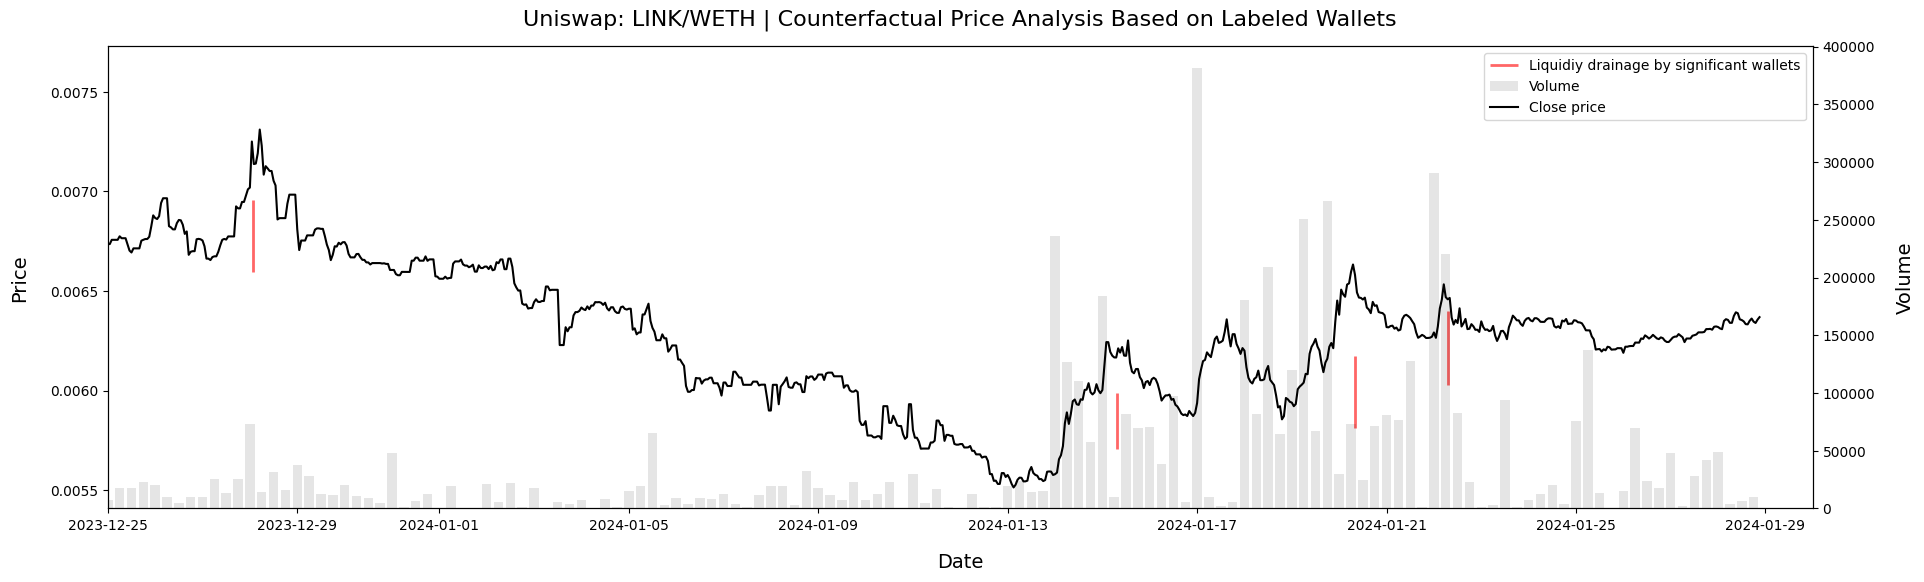

In [14]:
dakko_client.plot_counterfactual_price_liquidity(
    swaps_1h,
    swaps_vol,
    mints,
    burns,
    symbol="LINK/WETH",
    dex="uniswap",
    s_start_dt=s_start_dt,
    s_end_dt=s_end_dt,
    liq_start_dt=liq_start_dt,
    liq_end_dt=liq_end_dt,
    figsize=(22, 6),
)

Go deep to consider participants of significant events


In [46]:
liq_drainage_evts = dakko_client.get_liquidity_drainage_stats(
    mints, burns, liq_start_dt, liq_end_dt
)

liq_drainage_evts

Total wallets participated: 1


,transactionHash,wallet,timestamp,amount0,amount1,priceLower,priceUpper
215,0x03955c3099fe697805e4accc9323b3123400ff384dd0...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-22 07:05:35,0.0,617.400000,0.006026,0.006398
218,0x678f9df1a01bb074146ee3684cc42994cf16476c6f49...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-20 07:47:11,0.0,606.750000,0.005813,0.006172
320,0x45e5a58bdbd0675aa1f2dfa813e78d67b6da20b8fef9...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2023-12-23 16:17:47,0.0,681.406958,0.006475,0.006835
362,0x7068102b26afd110649cb210f10983168ff2d1951f5d...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2023-12-22 00:22:47,0.0,671.282511,0.006398,0.006835
393,0xb8aae81747e5f2a46d8e47ff0770ec2cd747698eef41...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-15 07:18:11,0.0,598.776316,0.005709,0.005990
538,0x3e9004cd7076c8da23ea228de1aed52634bd7a5db43a...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2023-12-28 01:40:23,0.0,686.760000,0.006593,0.006959


Analyze paritcipants


In [50]:
evts = analyze_significant_wallets(
    liq_drainage_evts, mints, burns, liq_start_dt, liq_end_dt
)

Understand where money goes


In [52]:
sw_evts_weth = dakko_client.get_significant_events_by_token(dakko_client.WETH, evts)

sw_evts_weth

,transactionHash,wallet,timestamp,event,value,to
0,0x7068102b26afd110649cb210f10983168ff2d1951f5d...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2023-12-22T00:22:47+00:00,Transfer,679.330780,0xc36442b4a4522e871399cd717abdd847ab11fe88
1,0xd1d491c3688d5f78ec3636df7844b5a10db404113111...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2023-12-22T02:01:11+00:00,Transfer,680.180000,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8
2,0x45e5a58bdbd0675aa1f2dfa813e78d67b6da20b8fef9...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2023-12-23T16:17:47+00:00,Transfer,685.527194,0xc36442b4a4522e871399cd717abdd847ab11fe88
3,0x3e9004cd7076c8da23ea228de1aed52634bd7a5db43a...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2023-12-28T01:40:23+00:00,Transfer,687.598703,0xc36442b4a4522e871399cd717abdd847ab11fe88
4,0xb8aae81747e5f2a46d8e47ff0770ec2cd747698eef41...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-15T07:18:11+00:00,Transfer,602.392755,0xc36442b4a4522e871399cd717abdd847ab11fe88
5,0xf3ad29db3322f2510205fb53ef0af9cdf0f5fda17c48...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-15T07:19:59+00:00,Transfer,606.750000,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8
6,0x678f9df1a01bb074146ee3684cc42994cf16476c6f49...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-20T07:47:11+00:00,Transfer,617.427873,0xc36442b4a4522e871399cd717abdd847ab11fe88
7,0x484ad8b90d852120ea87f315afba19f89ea0c6d776a7...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-20T16:25:59+00:00,Transfer,617.400000,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8
8,0x03955c3099fe697805e4accc9323b3123400ff384dd0...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-22T07:05:35+00:00,Transfer,619.223656,0xc36442b4a4522e871399cd717abdd847ab11fe88
9,0xb1d5e074a941d4c9f09d950e62430ef1550cee766dd8...,0xfa4c635e555d7f5464e24e48da6887cf74cc2f15,2024-01-22T07:08:11+00:00,Transfer,619.200000,0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8


Send message to websocket for notification purposes


In [55]:
dakko_client.sent_websocket_notification(sw_evts_weth)

Sending...
Sent message to Dakko websocket, check notifications
